In [2]:
import pandas as pd
import numpy as np
import datetime
import warnings
import os
import datetime
from datetime import timedelta, date
import json
import csv
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

In [15]:
def get_channel_files(house_path):
    filepath_array = []
    for x in os.listdir(house_path):
        if 'channel_' in x and x != "channel_1.dat":
            filepath_array.append(house_path+'/'+x)
    return filepath_array

In [16]:
def read_channel_file(filepath):
    df = pd.read_csv(filepath, sep='\\s+', names=['Timestamp','Reading'], parse_dates=['Timestamp'], header=0)
    return df

In [17]:
def resampling(input_df, time):
    dataframe = input_df.set_index('Timestamp')
    dataframe.index = pd.to_datetime(dataframe.index,unit = "s")
    resample = dataframe.resample(time)
    resampled_data = resample.sum()
    final_data = resampled_data.reset_index()
    return final_data

In [3]:
class to_serialised_on_counts():
    def __init__(self, data):
      self.data = data
      self.min_ = 0
      self.avg_ = 0
      self.max_ = 0
      self.find_min_max(flag = 1)

    def append_to_df(self, val):
      self.data.append(val)
      self.find_min_max()

    def find_min_max(self, flag = 0):
      if(flag == 0):
        val = self.data.loc[-1][-1]
        if( val > self.max_ ):
          self.max_ = val
        elif( val < self.min_ ):
          self.min_ = val
        self.avg_ += val/self.data.shape[0]
      elif(flag):
        self.max_ = max(self.data['Reading'])
        self.min_ = min(self.data['Reading'])
        self.avg_ = np.mean(self.data['Reading'].values)
        
      self.calc_thresh()

    def calc_thresh(self):
      self.thresh = (self.max_ - self.min_)/self.avg_

    def on_off(self):
      of = dict()
      for i in range(self.data.shape[0]):
        if(self.data.loc[i][1] > self.thresh):
            temp_date = str(self.data.loc[i][0]).split(" ")[0]
            of[temp_date] = of.setdefault(temp_date, 0)
            of[temp_date] += 1
# #           of[str(self.data.loc[i][0])]
#         else:
#           of.append(0)
      return of

In [27]:
def generate_channel_on_counts(filepath_list, resampling_time, labels_dict, output_files_location):
    results = dict()
    for file in filepath_list:
        df = read_channel_file(file)
        resampled_data = resampling(df, resampling_time)
        object_1 = to_serialised_on_counts(resampled_data)
        on_counts_dict = object_1.on_off()
        channel_id = file.split('/')[-1].split('.')[0]
        if('button' in channel_id):
            continue
#         json_obj = json.dumps(dict)
#         f = open(filename,"w")
#         f.write(json)
#         f.close()
        appliance = labels_dict[channel_id]
        results[appliance] = on_counts_dict
#         filepath = output_files_location + appliance + '.csv'
#         w = csv.writer(open(filepath, "w"))
#         for key, val in on_counts_dict.items():
#             w.writerow([key, val])
#         print(filename)
    return results

In [13]:
def get_labels(labels_file_path):
    labels_df = pd.read_csv(labels_file_path, sep='\\s+', names=['Channel_id','Appliance'])
    labels_df["Channel_id"] = ["channel_"+str(i) for i in range(1,labels_df.shape[0]+1)]
    labels_dict = dict()
    for row in labels_df.iterrows():
        labels_dict[row[1]["Channel_id"]] = row[1]["Appliance"]
    return labels_df, labels_dict

In [30]:
def get_min_max_dates(results):
    min_date = datetime.datetime.max.date()
    max_date = datetime.datetime.min.date()

    for appliance in results.keys():
        dates = list(results[appliance].keys())
        start_date = dates[0]
        end_date = dates[len(dates)-1]
        
        start_date_obj = datetime.datetime.strptime(start_date, "%Y-%m-%d")
        end_date_obj = datetime.datetime.strptime(end_date, "%Y-%m-%d")
        
        if(start_date_obj.date() < min_date):
            min_date = start_date_obj.date()
        
        if(end_date_obj.date() > max_date):
            max_date = end_date_obj.date()

    return min_date, max_date

In [31]:
def daterange(date1, date2):
    for n in range(int ((date2 - date1).days)+1):
        yield date1 + timedelta(n)

In [32]:
def get_dates_list(min_date, max_date):
    Dates = []
    start_dt = min_date
    end_dt = max_date
    for dt in daterange(start_dt, end_dt):
        Dates.append(dt.strftime("%Y-%m-%d"))
    return Dates

In [33]:
def add_missing_dates(results, date_list):
    for appliance in results.keys():
        for date in date_list:
            if date not in list(results[appliance].keys()):
                results[appliance][date] = 0
    return results

In [38]:
def get_percent_usage(results):
    appliance_usage_dict = dict()
    for appliance in results.keys():
        sum_of_hours = 0
        percent_usage = 0
        for date in results[appliance].keys():
            sum_of_hours += results[appliance][date]
        percent_usage = (sum_of_hours * 100)/(len(list(results[appliance])) * 48)
        appliance_usage_dict[appliance] = percent_usage
    return appliance_usage_dict

In [105]:
def plot_appliance(appliance, xlabel, ylabel, appliance_usage_df):
    fig, ax = plt.subplots(figsize=(20,8))

    ax.plot(appliance_usage_df[xlabel], appliance_usage_df[ylabel]/2)
    
    ax.set(xlabel = xlabel, ylabel = ylabel)
    
    # rotate and align the tick labels so they look better
    fig.autofmt_xdate()
    plt.rcParams.update({'font.size': 16})
    plt.rcParams.update({'axes.titlesize': 16})
    plt.rcParams.update({'xtick.labelsize': 16})
    plt.rcParams.update({'ytick.labelsize': 16})
    
#     SMALL_SIZE = 8
#     MEDIUM_SIZE = 10
#     BIGGER_SIZE = 12

#     plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
#     plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
#     plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
#     plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
#     plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
#     plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
#     plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    
    # use a more precise date string for the x axis locations in the
    # toolbar
    ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
    ax.set_title("Usage of " + appliance +" over time")

In [40]:
def plot_appliance_usage(appliance, appliance_dict):
    appliance_usage_df = pd.DataFrame({"Dates" : pd.to_datetime(list(appliance_dict[appliance].keys())), "Hours" : list(appliance_dict[appliance].values())})
    appliance_usage_df.sort_values(by=['Dates'], inplace = True)
    plot_appliance(appliance, "Dates", "Hours", appliance_usage_df)    

In [41]:
def plot_bar_graph(xlabel, ylabel, df):
    fig= plt.figure(figsize=(20,8))
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.xticks(rotation='vertical')
    plt.bar(df[xlabel], df[ylabel]) 

## Get labels from label file

In [24]:
labels_df_house_2, labels_dict_house_2 = get_labels("../../../../Dataset/ukdale/house_2/labels.dat")

In [116]:
labels_df_house_2

,Channel_id,Appliance
0,channel_1,aggregate
1,channel_2,laptop
2,channel_3,monitor
3,channel_4,speakers
4,channel_5,server
5,channel_6,router
6,channel_7,server_hdd
7,channel_8,kettle
8,channel_9,rice_cooker
9,channel_10,running_machine


## Get resampled channel data

In [25]:
path_to_ukdale_dataset = "../../../../Dataset/ukdale/house_2"
filepath_list = get_channel_files(path_to_ukdale_dataset)
path_to_resampled_channel_on_count_data = "./Channel_On_Count_data/House_2/"

## Generate a dictionary with appliances as keys and their usage data for each day as value

In [28]:
all_appliance_on_count_dict = generate_channel_on_counts(filepath_list, "30min", labels_dict_house_2, path_to_resampled_channel_on_count_data)

In [50]:
# all_appliance_on_count_dict

## Find min and max dates

In [35]:
min_date, max_date = get_min_max_dates(all_appliance_on_count_dict)

## Insert missing dates between min and max dates in appliance on count dictionary

In [ ]:
date_list = get_dates_list(min_date, max_date)
all_appliance_on_count_dict = add_missing_dates(all_appliance_on_count_dict, date_list)

## Get % usage of each appliance over the period between min and max date

In [43]:
appliance_usage_dict = get_percent_usage(all_appliance_on_count_dict)

## Plot all appliance % usage 

In [48]:
appliance_usage_df = pd.DataFrame({"Appliances" : list(appliance_usage_dict.keys()), "% Usage" : list(appliance_usage_dict.values())})

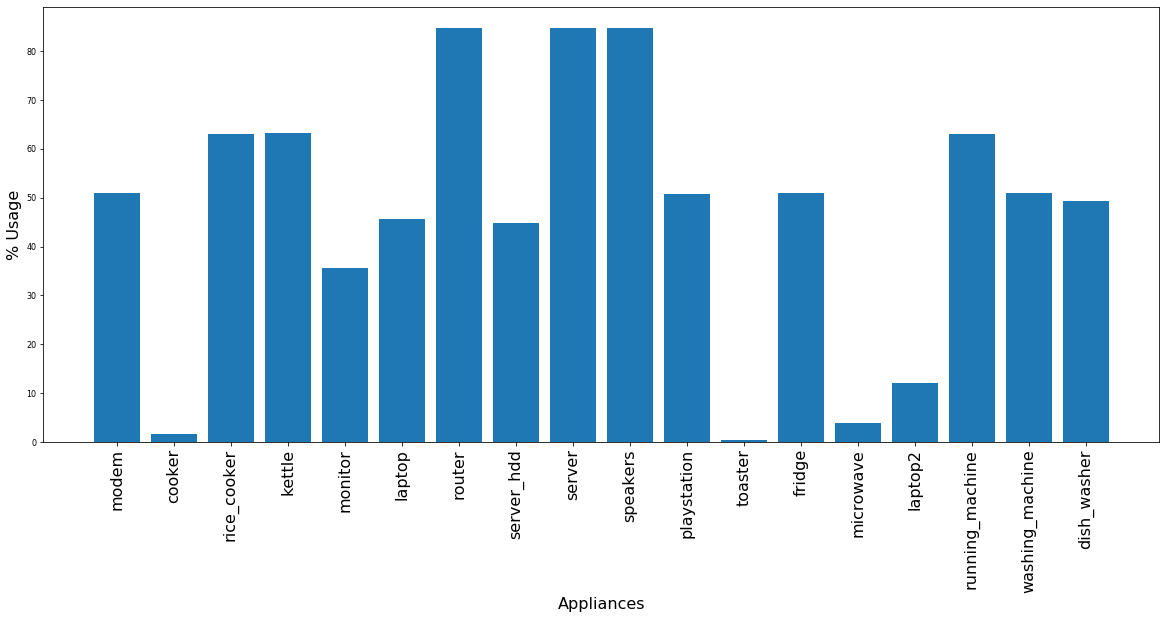

In [106]:
plot_bar_graph("Appliances", "% Usage", appliance_usage_df)

## Plot individual appliance usage pattern over the period of min to max date

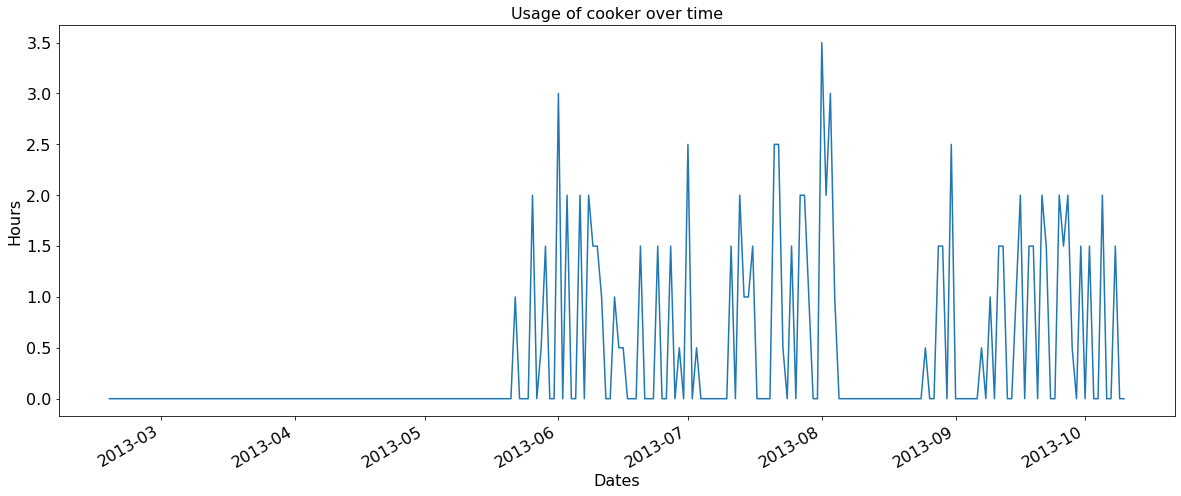

In [114]:
plot_appliance_usage("cooker", all_appliance_on_count_dict)

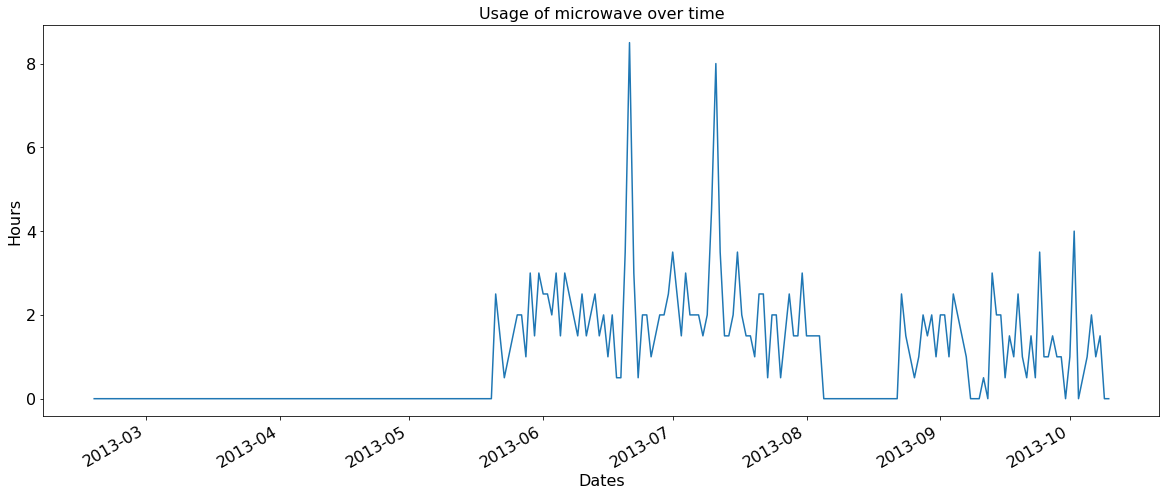

In [113]:
plot_appliance_usage("microwave", all_appliance_on_count_dict)

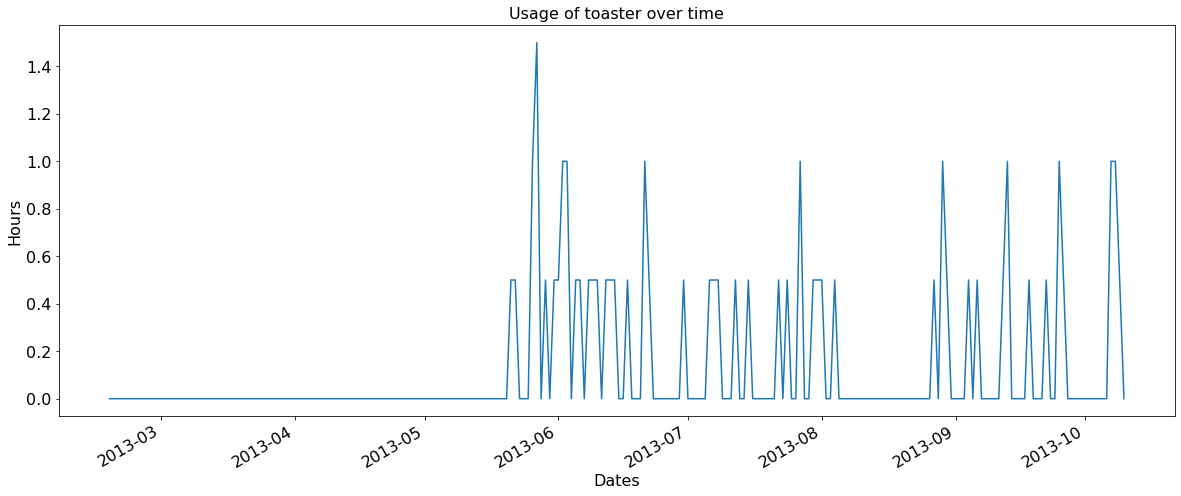

In [108]:
plot_appliance_usage("toaster", all_appliance_on_count_dict)

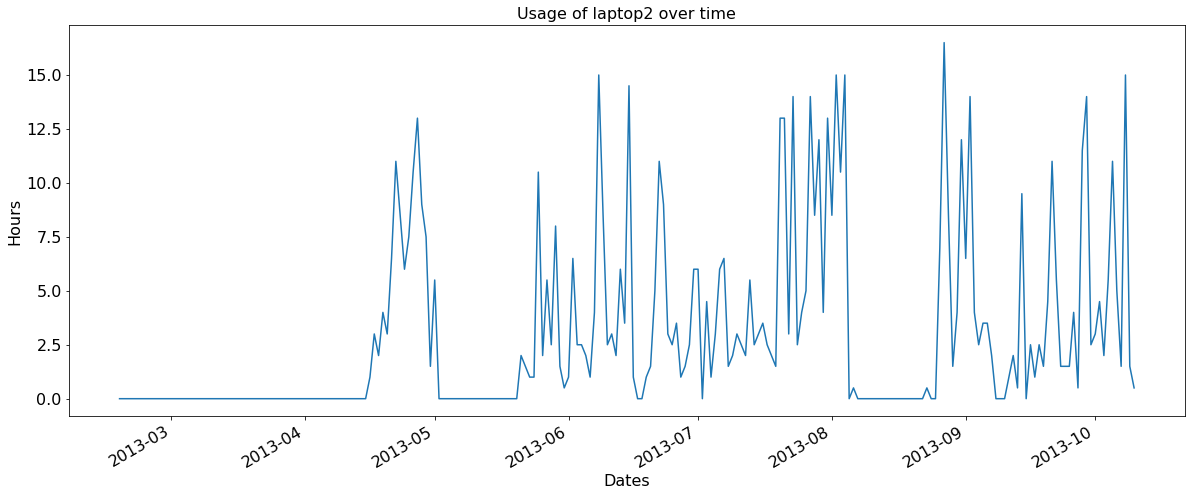

In [109]:
plot_appliance_usage("laptop2", all_appliance_on_count_dict)

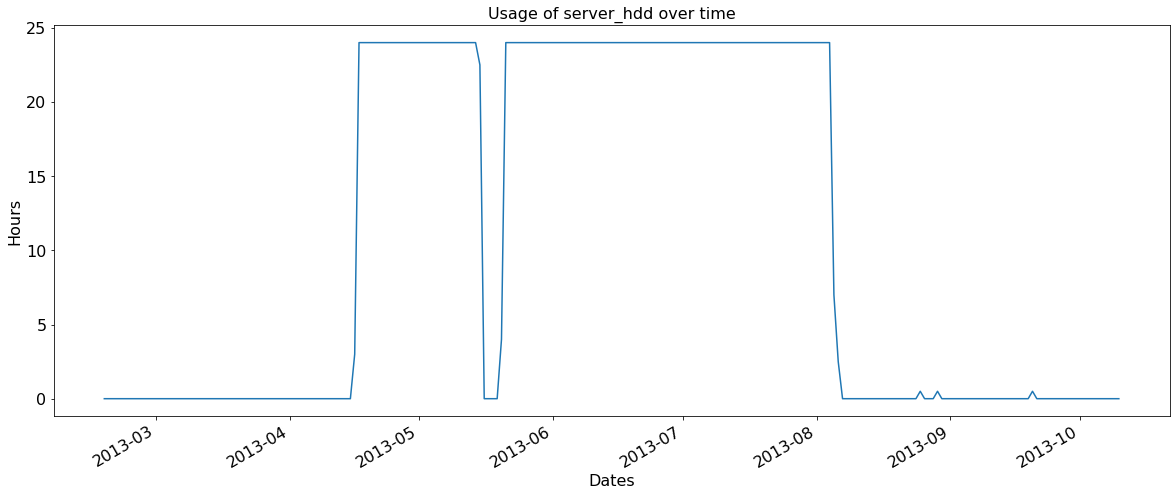

In [110]:
plot_appliance_usage("server_hdd", all_appliance_on_count_dict)

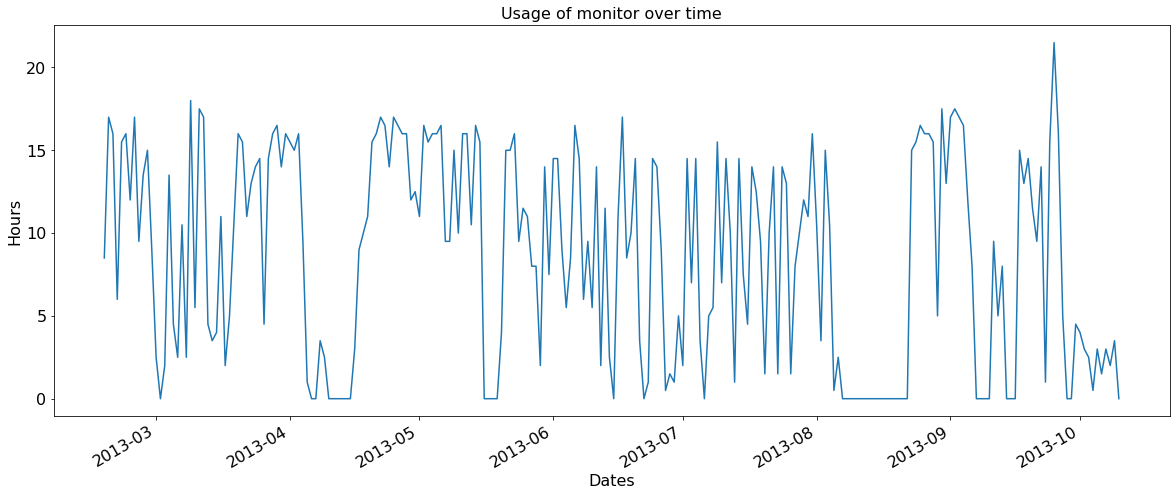

In [111]:
plot_appliance_usage("monitor", all_appliance_on_count_dict)

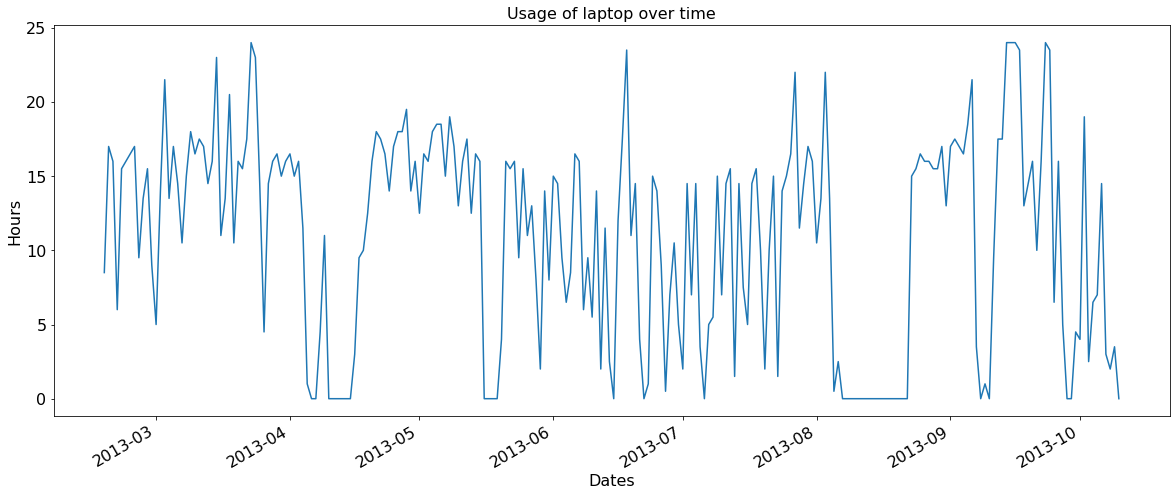

In [112]:
plot_appliance_usage("laptop", all_appliance_on_count_dict)

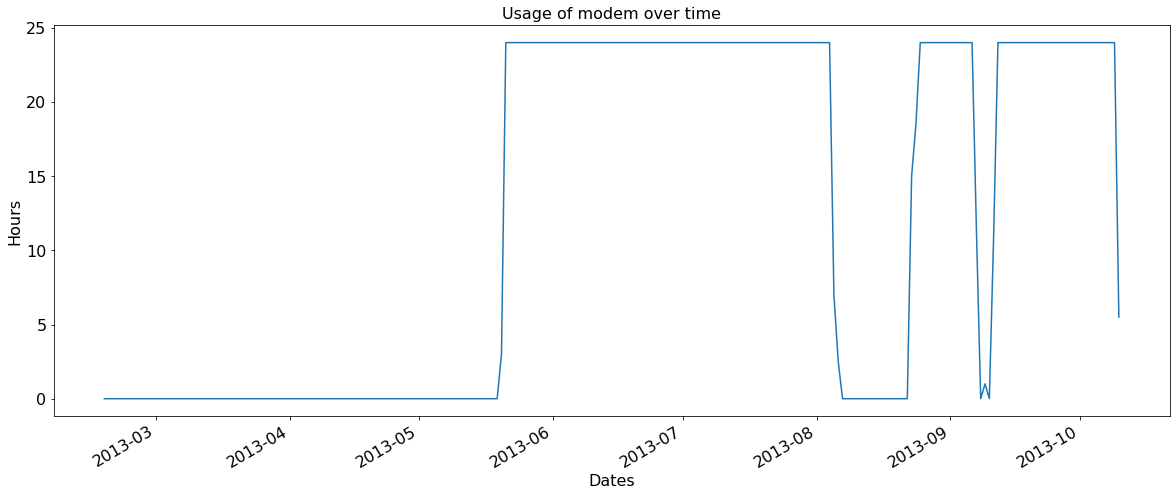

In [117]:
plot_appliance_usage("modem", all_appliance_on_count_dict)

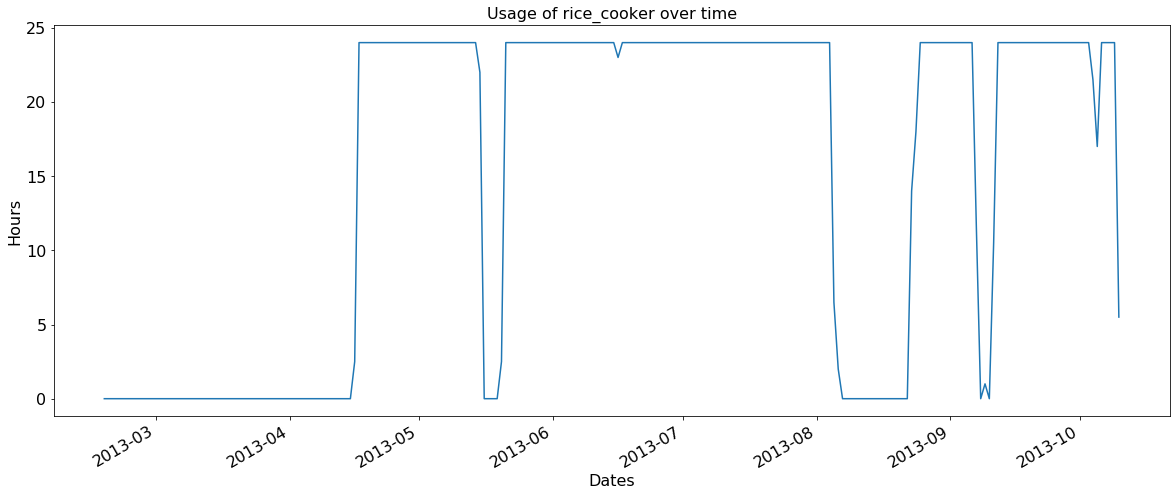

In [115]:
plot_appliance_usage("rice_cooker", all_appliance_on_count_dict)

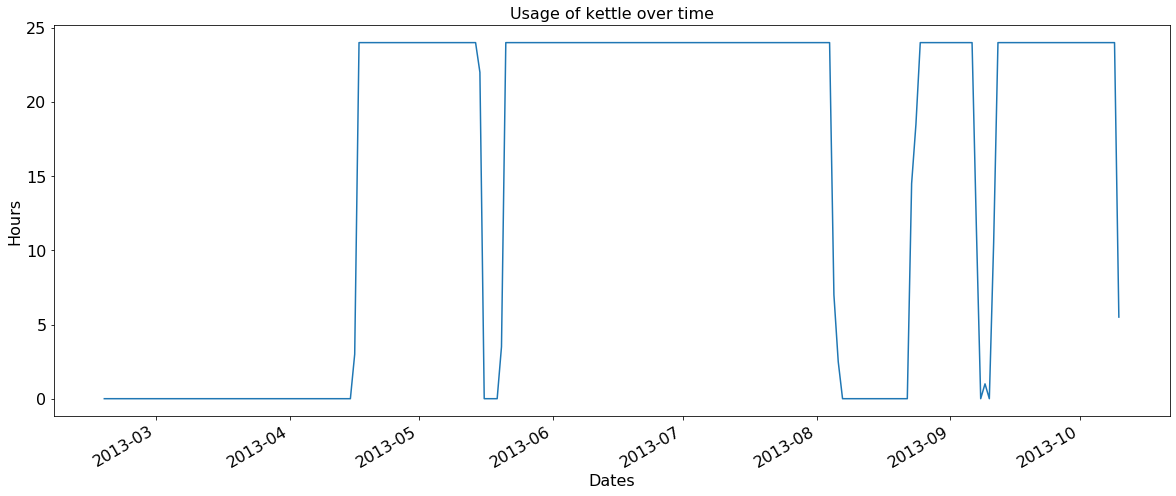

In [118]:
plot_appliance_usage("kettle", all_appliance_on_count_dict)

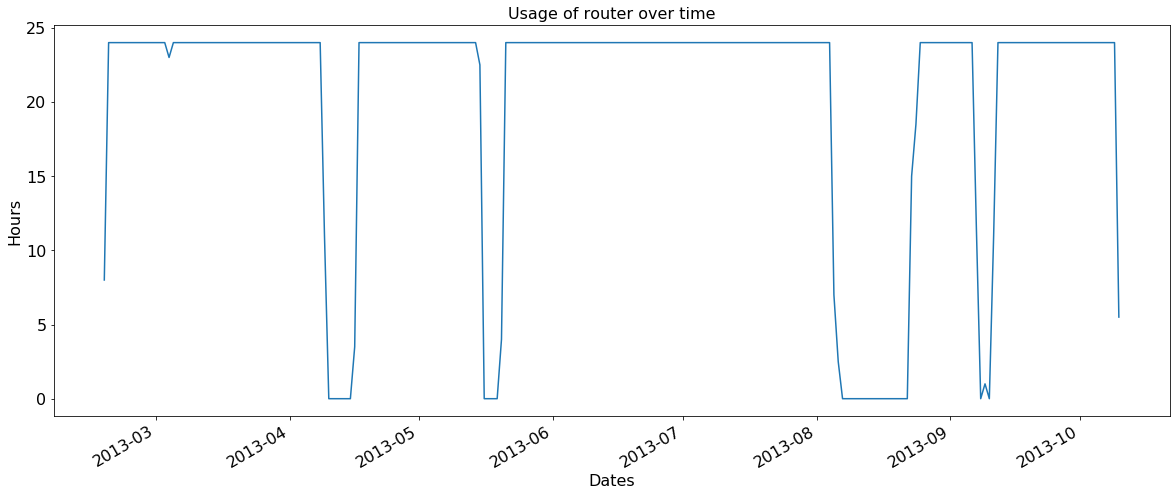

In [119]:
plot_appliance_usage("router", all_appliance_on_count_dict)

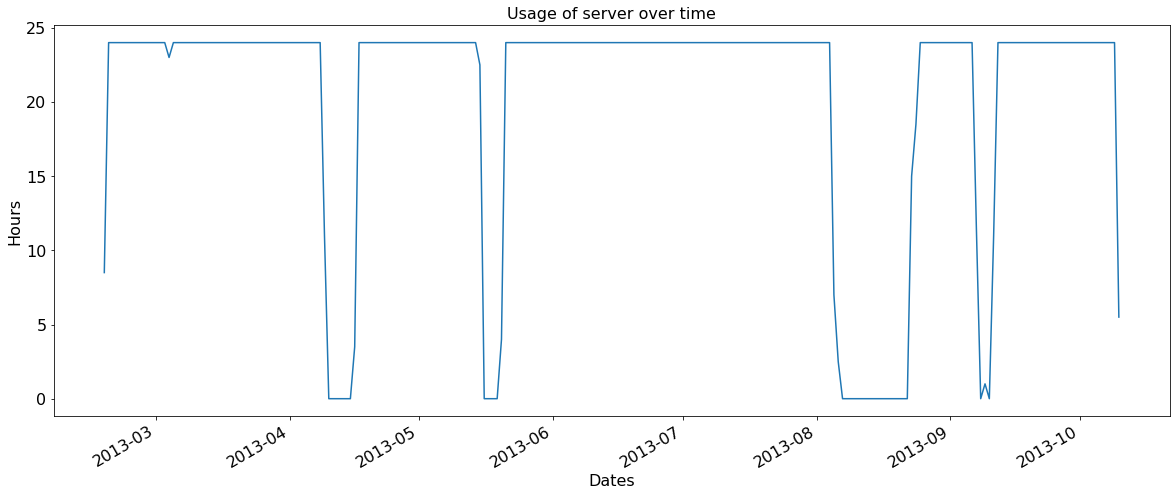

In [120]:
plot_appliance_usage("server", all_appliance_on_count_dict)

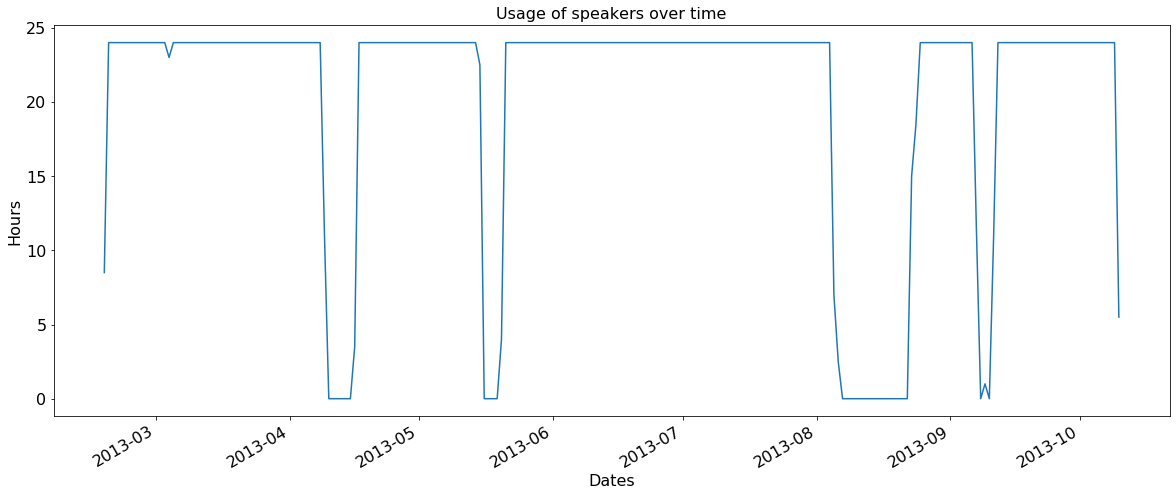

In [122]:
plot_appliance_usage("speakers", all_appliance_on_count_dict)

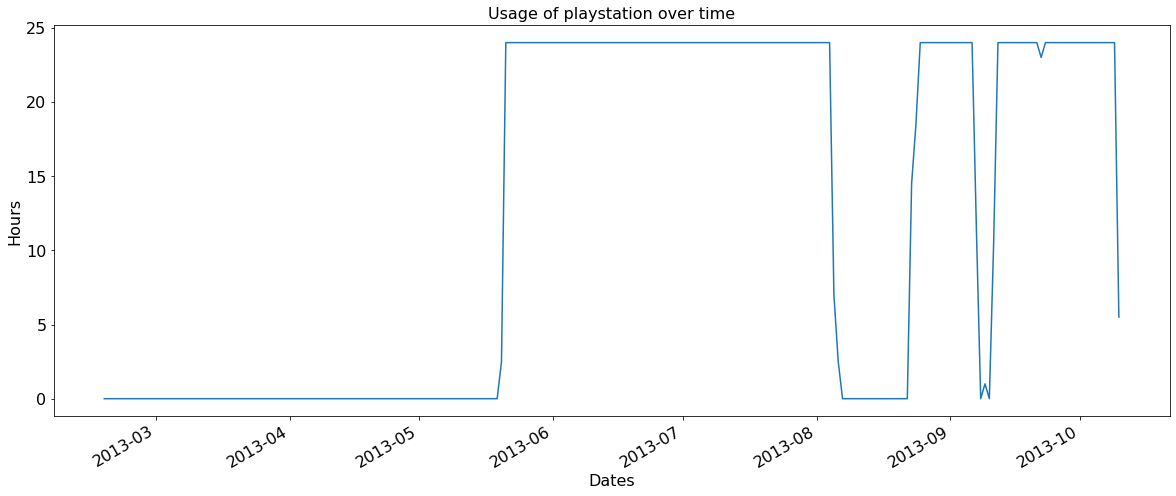

In [123]:
plot_appliance_usage("playstation", all_appliance_on_count_dict)

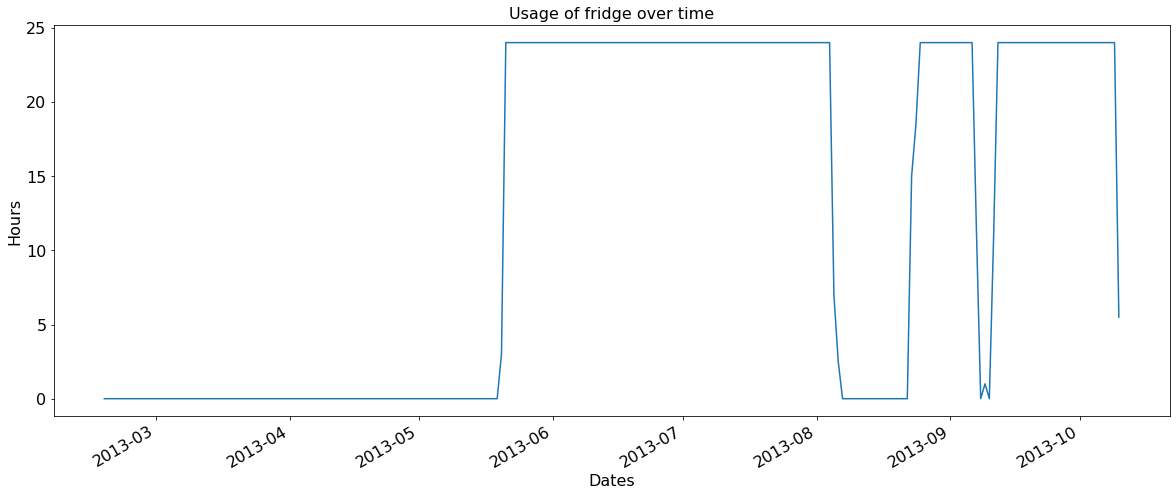

In [124]:
plot_appliance_usage("fridge", all_appliance_on_count_dict)

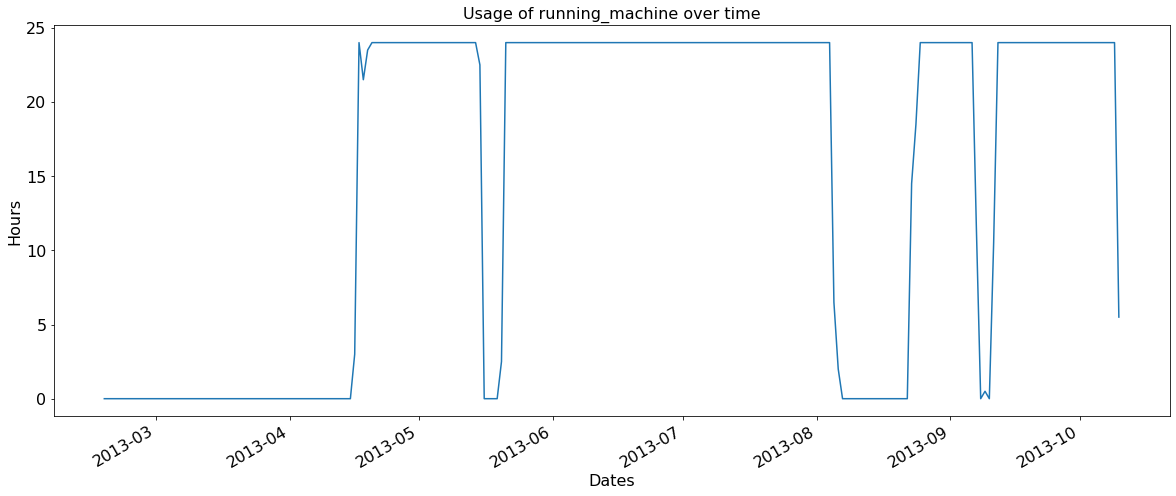

In [125]:
plot_appliance_usage("running_machine", all_appliance_on_count_dict)

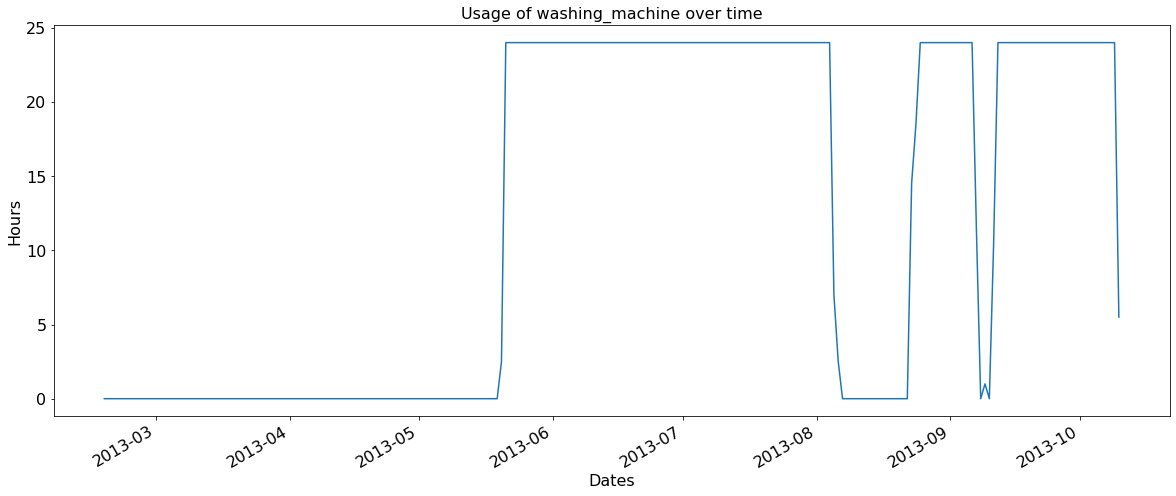

In [127]:
plot_appliance_usage("washing_machine", all_appliance_on_count_dict)

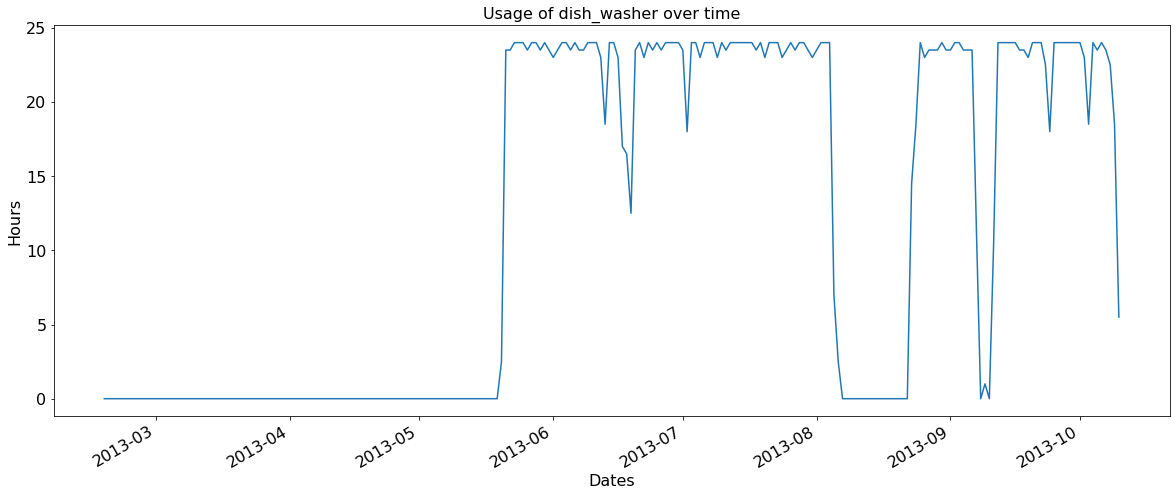

In [129]:
plot_appliance_usage("dish_washer", all_appliance_on_count_dict)